In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
# sys.path.append(os.path.abspath('..'))
# from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 4, 'lines.linewidth': 0.5, 'figure.dpi': 150})


In [2]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.tail(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.35611
2023-06-02 00:00:00,1685664000000,26817.93,27017.00,26505.00,27000.00,7016.04160
2023-06-02 04:00:00,1685678400000,27000.01,27213.00,26949.40,27049.65,6856.64454
2023-06-02 08:00:00,1685692800000,27049.65,27183.07,27049.38,27130.75,3577.11000


In [4]:
ldf = odf[['open', 'high', 'low', 'close']].apply(np.log)
ldf.head(4)

,open,high,low,close
dtime,,,,
2017-08-17 04:00:00,8.357372,8.377929,8.357334,8.377929
2017-08-17 08:00:00,8.374089,8.408581,8.374089,8.395545
2017-08-17 12:00:00,8.397522,8.408581,8.374112,8.378469
2017-08-17 16:00:00,8.378467,8.379043,8.343016,8.372221


In [38]:
# ldf.rolling(fuper).max().shift(-fuper)
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [103]:
fuper = 6 * 2

ldf['fu_high'] = ldf.high.rolling(fuper).max().shift(-fuper)
ldf['fu_low'] = ldf.low.rolling(fuper).min().shift(-fuper)
ldf['fu_high_pct'] = ldf.fu_high - ldf.close
ldf['fu_low_pct'] = ldf.fu_low - ldf.close

q = np.linspace(0, 1, 6)

# ldf
ldf['cat_low_pct'] = pd.qcut(ldf.fu_low_pct, q, precision=3)
ldf['cat_high_pct'] = pd.qcut(ldf.fu_high_pct, q, precision=3)
# ldf.cat_high_pct.value_counts()
ldf['cat_low_rbound'] = ldf['cat_low_pct'].apply(lambda x: x.right)
ldf['cat_high_rbound'] = ldf['cat_high_pct'].apply(lambda x: x.right)
# ldf.cat_high_pct.apply(lambda x: print(x.right))
# ldf['cat_fu'] = ldf.apply(lambda x: '{x.right}')
ldf['cat_fu'] = ldf.cat_low_rbound.astype(str) + "__" + ldf.cat_high_rbound.astype(str)
ldf['cat_fu'].value_counts()
# pd.qcut(ldf.fu_high, np.linspace(0, 1, 6))

cat_fu
0.00092__0.353       1045
-0.0641__0.00982      947
-0.0357__0.00982      731
0.00092__0.0614       651
-0.00987__0.0614      637
-0.0357__0.0203       619
-0.0205__0.035        614
-0.00987__0.353       581
-0.0641__0.0203       562
-0.00987__0.035       558
-0.0205__0.0203       551
-0.0357__0.035        514
-0.0205__0.00982      495
-0.0205__0.0614       484
-0.00987__0.0203      472
0.00092__0.035        433
-0.0641__0.035        413
-0.0357__0.0614       412
-0.0205__0.353        388
-0.0641__0.0614       349
0.00092__0.0203       329
-0.00987__0.00982     285
-0.0641__0.353        262
-0.0357__0.353        257
0.00092__0.00982       75
nan__nan               12
Name: count, dtype: int64

<Axes: xlabel='dtime'>

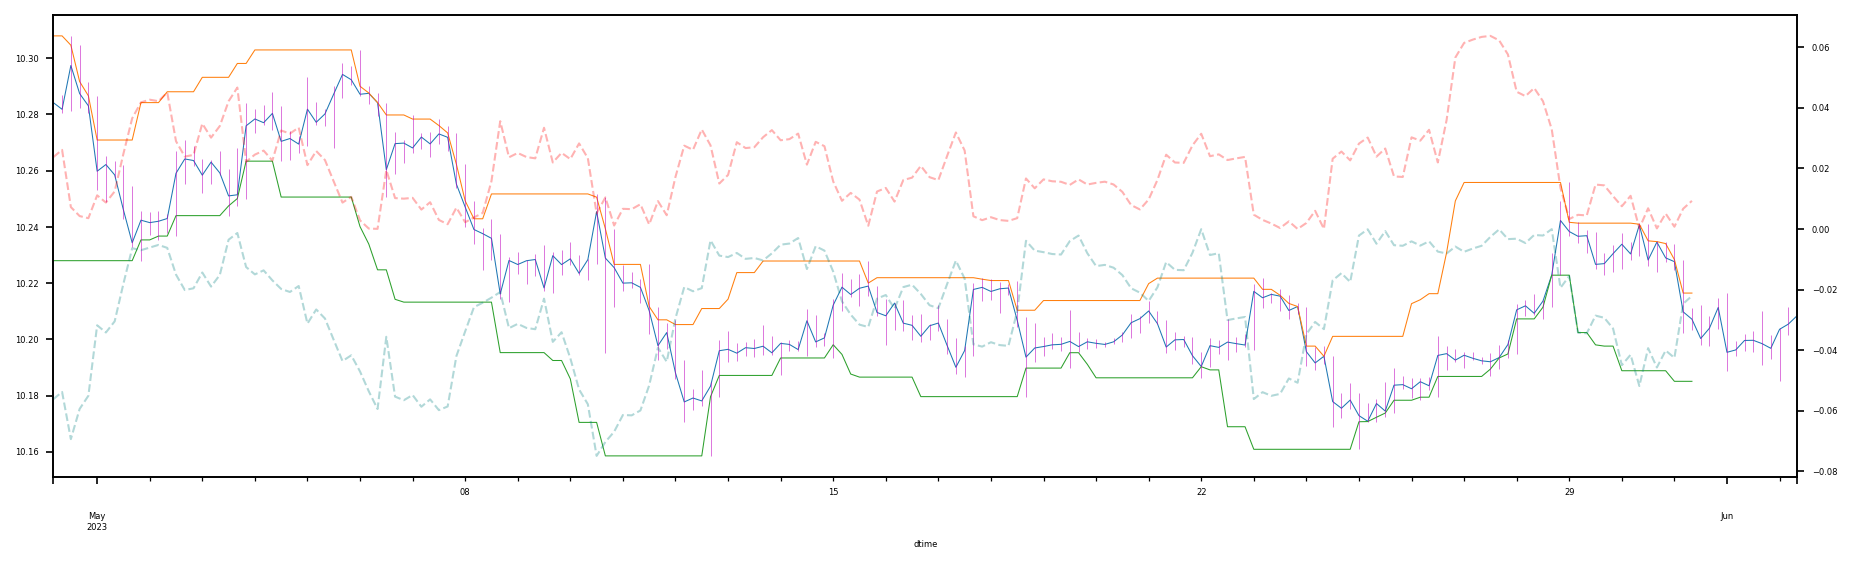

In [84]:
wdf = ldf[-200:]

fig = plt.figure(figsize=(15,4))

ax = wdf.close.plot()
wdf.fu_high.plot(ax=ax)
wdf.fu_low.plot(ax=ax)
ax.vlines(wdf.index, wdf.low, wdf.high, lw=0.25, color='m')

secax = ax.twinx()
wdf.fu_high_pct.plot(ax=secax, lw=1, linestyle='--', alpha=0.3, color='red')
wdf.fu_low_pct.plot(ax=secax, lw=1, linestyle='--', alpha=0.3, color='teal')

In [27]:
from pandas.api.types import CategoricalDtype

zdf = pd.melt(ldf[['open', 'high', 'low', 'close']], ignore_index=False).sort_values(by=['dtime', 'variable'])
cat_ohlc = CategoricalDtype(
    ['open', 'high', 'low', 'close'], 
    ordered=True
)
zdf['variable'] = zdf.variable.astype(cat_ohlc)
zdf.sort_values(['dtime', 'variable'], inplace=True)
zdf.value[-1000:]

dtime
2023-04-21 20:00:00    10.213905
2023-04-21 20:00:00    10.218649
2023-04-21 20:00:00    10.208211
2023-04-21 20:00:00    10.213280
2023-04-22 00:00:00    10.213280
                         ...    
2023-06-02 04:00:00    10.205429
2023-06-02 08:00:00    10.205429
2023-06-02 08:00:00    10.210350
2023-06-02 08:00:00    10.205419
2023-06-02 08:00:00    10.208423
Name: value, Length: 1000, dtype: float64

<Axes: >

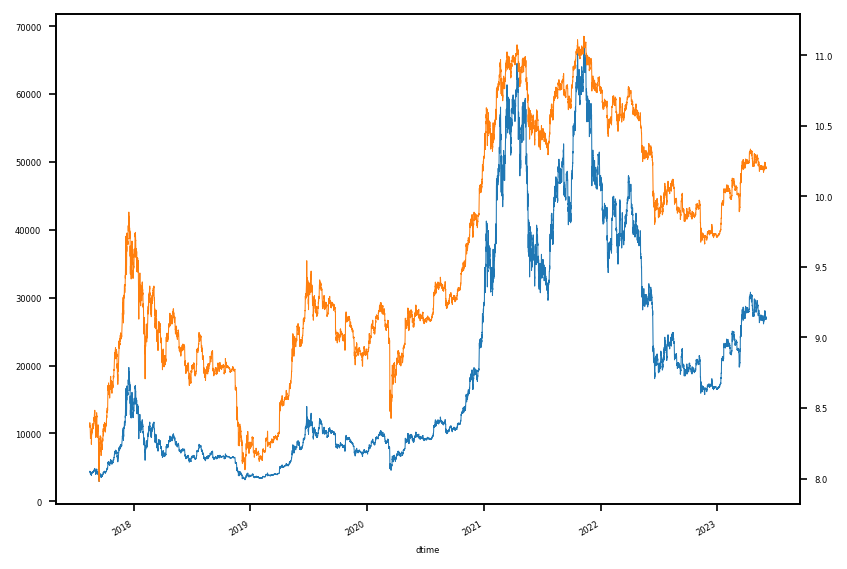

In [6]:
ax1 = odf.close.plot()
ldf.close.plot(ax=ax1, secondary_y=True)

In [34]:
l = 14
# np.split(odf.close[- (odf.shape[0] // l * l):] ,l)
X_train = to_time_series_dataset(np.split(odf.close[- (odf.shape[0] // l * l):] ,l))

In [7]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [11]:
ldf[-2000:]

,open,high,low,close
dtime,,,,
2022-07-04 04:00:00,9.857629,9.862092,9.856549,9.858522
2022-07-04 08:00:00,9.858522,9.896246,9.857969,9.893765
2022-07-04 12:00:00,9.893764,9.910613,9.878008,9.893511
2022-07-04 16:00:00,9.893512,9.905984,9.887201,9.894951
2022-07-04 20:00:00,9.894950,9.921033,9.890096,9.915254
...,...,...,...,...
2023-06-01 16:00:00,10.199676,10.210053,10.190770,10.198493
2023-06-01 20:00:00,10.198493,10.201478,10.192918,10.196826
2023-06-02 00:00:00,10.196826,10.204222,10.185089,10.203592


In [12]:
# X = to_time_series_dataset(xdf[['close','low','high']].values.T)
# X_scaled = TimeSeriesScalerMinMax().fit_transform(X)
# X_scaled[:5]

array([[[0.02350761],
        [0.02103598],
        [0.02171899],
        ...,
        [0.73529991],
        [0.73875671],
        [0.74440316]],

       [[0.02973527],
        [0.03092821],
        [0.03202265],
        ...,
        [0.71081541],
        [0.7416375 ],
        [0.74857177]],

       [[0.01836491],
        [0.01753416],
        [0.01890952],
        ...,
        [0.72471992],
        [0.73826621],
        [0.73619764]]])

Euclidean k-means
0.000 --> 0.000 --> 
DBA k-means
Init 1
0.000 --> 0.000 --> 
Init 2
0.000 --> 0.000 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


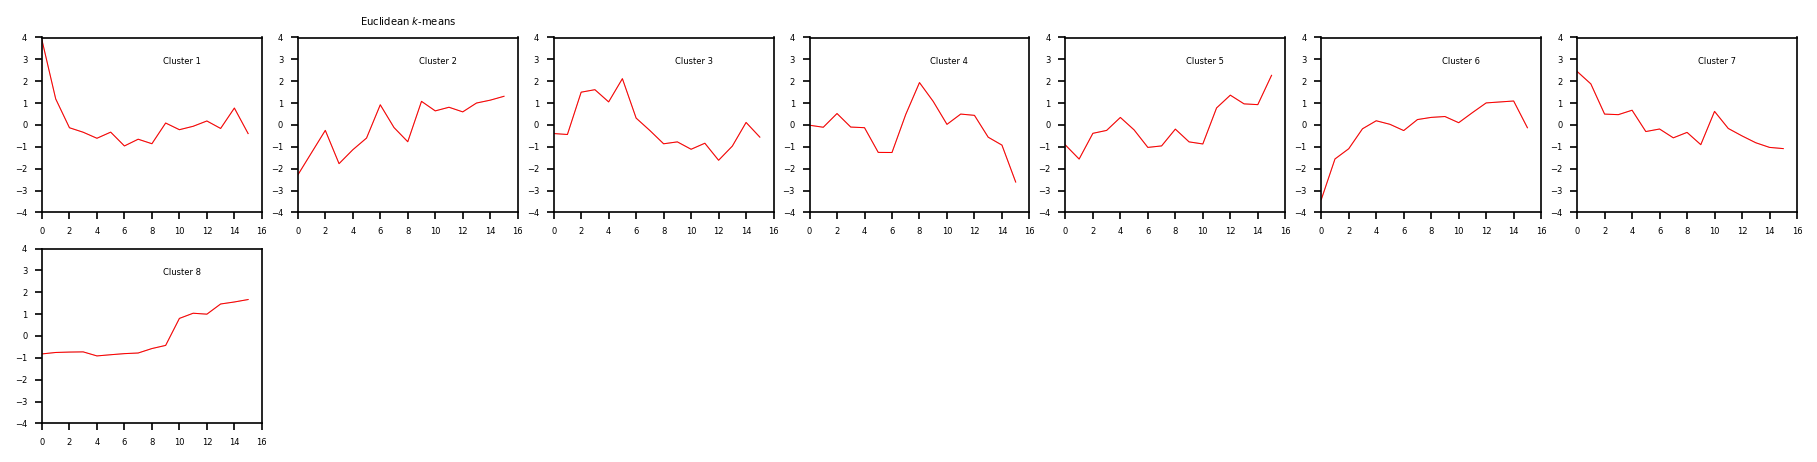

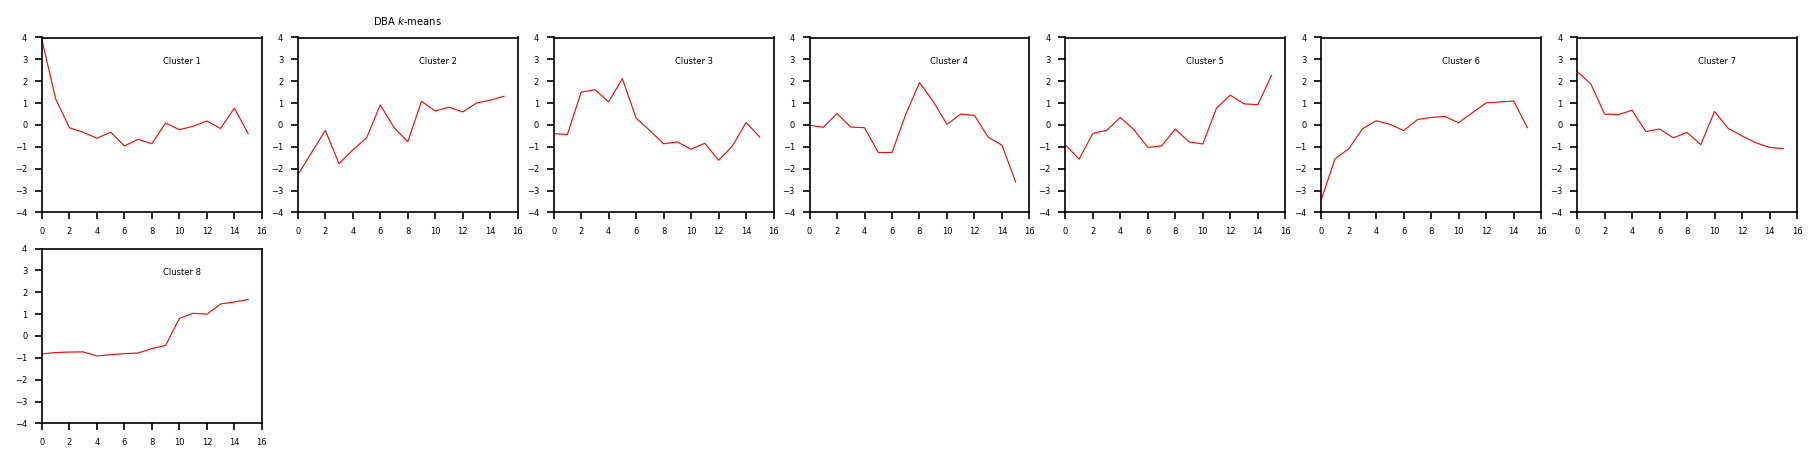

In [31]:

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

xdf = zdf.iloc[-4 * 2000:]
# wdf.columns = ['close']
seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# X_train = to_time_series_dataset(odf[['close']].values.T)
l = 4 * 2
n_clusters = 8
X_train = to_time_series_dataset(np.split(xdf.value[- (xdf.shape[0] // l * l):] ,l))
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=l*2).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)


ppl = 7
ppc = (n_clusters // ppl + 1) 
pr = ppc * 3

plt.figure(figsize=(12,3))

for yi in range(n_clusters):
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()

# DBA-k-means
plt.figure(figsize=(12,3))
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(n_clusters):
    # plt.subplot(3, 3, 4 + yi)
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
plt.tight_layout()

# # Soft-DTW-k-means
# plt.figure(figsize=(12,3))
# print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
#                            metric="softdtw",
#                            metric_params={"gamma": .01},
#                            verbose=True,
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)

# for yi in range(n_clusters):
#     plt.subplot(ppc , ppl, yi + 1 )
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")

# plt.tight_layout()


plt.show()